In [1]:
import cv2
import numpy as np
import sys
import matplotlib
from matplotlib import pyplot as plt
import pylab as pl

from filters import GrayscaleNormalizer

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

FOLDER_PATH = '/Users/delinwang/Desktop/Concrete Crack Images for Classification.rar Folder/'
FOLDER_PATH = 'C:/Users/Dominic/Desktop/Concrete Crack Images for Classification/'

In [2]:
img = cv2.imread(FOLDER_PATH + 'Positive/00001.jpg', 0).astype(np.float32)
normalize_grayscale = GrayscaleNormalizer()
img2 = normalize_grayscale(img)

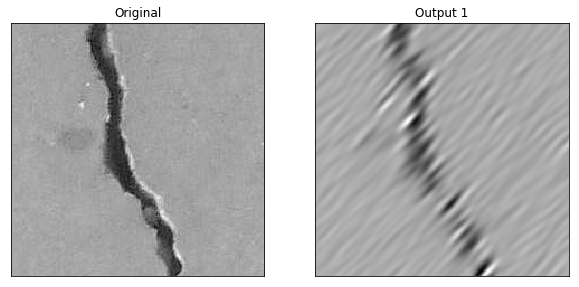

In [3]:
#gabor = cv2.getGaborKernel(ksize, sigma, theta, lambda, gamma, psi, ktype)
ksize = 31
sigma = 4
theta = np.pi/4
lm = 10
gamma = 0.5
psi = 0
gabor = cv2.getGaborKernel((ksize,ksize), sigma, theta, lm, gamma, psi)

#apply filter
dstx = cv2.filter2D(img,-1, gabor)

plt.figure(figsize=(10,5))
plt.subplot(121),plt.imshow(img, cmap='gray')
plt.title('Original'),plt.xticks([]),plt.yticks([])
plt.subplot(122),plt.imshow(np.abs(dstx), cmap='gray')
plt.title('Output 1'),plt.xticks([]),plt.yticks([])
plt.show()

In [4]:
def build_filters():
    filters = []
    ksize = [17,25,31] # size of kernel
    lamda = 15#np.pi/2.0 #wavlength
    for theta in np.arange(0, np.pi/2, np.pi/4): #direction of gabor filter，0°，45°，90°，135°，4 in total
        for K in range(3): 
            kern = cv2.getGaborKernel((ksize[K], ksize[K]), 4.0, theta, lamda, 0.5, 0, ktype=cv2.CV_32F)
            kern /= 1.5*kern.sum()
            filters.append(kern)
    return filters

def process(img, filters):
    accum = np.zeros_like(img)
    for kern in filters:
        fimg = cv2.filter2D(img, -1, kern)
        np.maximum(accum, fimg, accum)
    return accum

def getGabor(img,filters):
    res = [] #to store the results after filtering 
    for i in range(len(filters)):        
        res1 = process(img, filters[i])
        res.append(np.asarray(res1))

    pl.figure(2)
    for temp in range(len(res)):
        pl.subplot(4,3,temp+1)
        pl.imshow(res[temp], cmap='gray' )
    pl.show()

    return res  #return series of plots generated by gabor filters


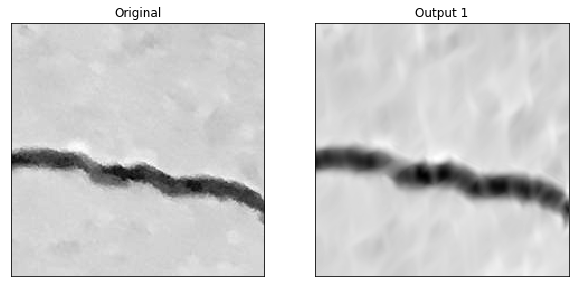

In [5]:
img = cv2.imread(FOLDER_PATH + 'Positive/01068.jpg', 0).astype(np.float32) 
normalize_grayscale = GrayscaleNormalizer()
img2 = normalize_grayscale(img)
filters = build_filters()
#mygab = getGabor(img,filters)
myfiltered = process(img2,filters)

plt.figure(figsize=(10,5))
plt.subplot(121),plt.imshow(img, cmap='gray')
plt.title('Original'),plt.xticks([]),plt.yticks([])
plt.subplot(122),plt.imshow(np.abs(myfiltered), cmap='gray')
plt.title('Output 1'),plt.xticks([]),plt.yticks([])
plt.show()

In [6]:
import helper

def do_gabor_filter(img, normalize_grayscale):
    img2 = normalize_grayscale(img)
    myfiltered = process(img2, filters)
    myfiltered = myfiltered.reshape(-1)
    return myfiltered
    
filters = build_filters()
normalize_grayscale = GrayscaleNormalizer()

mytrainX, mytrainY = helper.get_concrete_data(range(1, 11), range(1, 11), path = FOLDER_PATH)
mytrainX = np.array(list(do_gabor_filter(x, normalize_grayscale) for x in mytrainX))

# mytrainX = []
# mytrainY = np.concatenate((np.ones(1000), np.zeros(1000)),0)
# A_kp=None
# for i in range(1,1001):
#     txt = '/Users/delinwang/Desktop/Concrete Crack Images for Classification.rar Folder/Positive/0'+str(i).zfill(4)+'.jpg'
#     img = cv2.imread(txt, 0).astype(np.float32)
#     img2, A_kp = normalize_grayscale(img, beta=0.75, image_id_k = i, A_kp=A_kp)
#     myfiltered = process(img2,filters)
#     myfiltered = myfiltered.reshape(-1)
#     mytrainX.append(myfiltered)
     
# A_kp=None    
# for i in range(1,1001):
#     txt = '/Users/delinwang/Desktop/Concrete Crack Images for Classification.rar Folder/Negative/0'+str(i).zfill(4)+'.jpg'
#     img = cv2.imread(txt, 0).astype(np.float32)
#     img2, A_kp = normalize_grayscale(img)
#     myfiltered = process(img2,filters)
#     myfiltered = myfiltered.reshape(-1)
#     mytrainX.append(myfiltered) 
# mytrainX = np.asarray(mytrainX)

## SVM
good for positive dataset 100% 

bad for negative dataset 25%

# KNN
3 nearest neighbor performs the best 

good for negative dataset 100%

bad for positive dataset 50%

# Linear Regresseion
Positive 62.5%

Negative 96.7%

# Logistic Regression
positive 74.1%

negative 99.2%

In [7]:
from sklearn import svm
clf = svm.SVC()
clf.fit(mytrainX, mytrainY) 

from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(mytrainX, mytrainY) 

from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(mytrainX, mytrainY)
logistic = linear_model.LogisticRegression(C=1e5)
logistic.fit(mytrainX, mytrainY)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [13]:
pos_size = 10
neg_size = 10

def do_gabor_filter(img, normalize_grayscale):
    img2 = normalize_grayscale(img)
    myfiltered = process(img2,filters)
    myfiltered = myfiltered.reshape(-1)
    return myfiltered    

filters = build_filters()
normalize_grayscale = GrayscaleNormalizer()

testX, testY = helper.get_concrete_data(range(1601, 1601+pos_size), range(1601, 1601+neg_size), path = FOLDER_PATH)
testX = np.array(list(do_gabor_filter(x, normalize_grayscale) for x in testX))

logipred = logistic.predict(testX)
svmpred  = clf.predict(testX)
regrpred  = neigh.predict(testX)
knnpred = regr.predict(testX)

logipospred = logipred[:pos_size]
svmpospred  = svmpred[:pos_size]
knnpospred  = regrpred[:pos_size]
regrpospred = knnpred[:pos_size]

loginegpred = logipred[pos_size:]
svmnegpred  = svmpred[pos_size:]
regrnegpred = regrpred[pos_size:]
knnnegpred  = knnpred[pos_size:]

# svmpospred  = []
# logipospred = []
# regrpospred = []
# knnpospred  = []
# A_kp=None
# for i in range(1,121):
#     j  = i + 1600
#     txt = FOLDER_PATH + 'Positive/0'+str(j).zfill(4)+'.jpg'
#     img = cv2.imread(txt, 0).astype(np.float32)
#     img2, A_kp = normalize_grayscale(img, beta=0.75, image_id_k = i, A_kp=A_kp)
#     myfiltered = process(img2,filters)
#     myfiltered = myfiltered.reshape(-1)
    
#     logipospred.append(logistic.predict([myfiltered]))
#     svmpospred.append(clf.predict([myfiltered]))
#     knnpospred.append(neigh.predict([myfiltered]))
#     regrpospred.append(regr.predict([myfiltered]))
 
        
    
# logipred = []
# svmpred  = []
# regrpred = []
# knnpred  = []
# A_kp=None
# for i in range(1,121):
#     j  = i + 1600
#     txt = FOLDER_PATH + 'Negative/0'+str(j).zfill(4)+'.jpg'
#     img = cv2.imread(txt, 0).astype(np.float32)
#     img2, A_kp = normalize_grayscale(img, beta=0.75, image_id_k = i, A_kp=A_kp)
#     myfiltered = process(img2,filters)
#     myfiltered = myfiltered.reshape(-1)
    
#     logipred.append(logistic.predict([myfiltered]))
#     svmpred.append(clf.predict([myfiltered]))
#     knnpred.append(neigh.predict([myfiltered]))
#     regrpred.append(logistic.predict([myfiltered]))


In [14]:
print ('svm pos, neg')
print (sum(svmpospred)/120)
print ((120-sum(svmnegpred))/120)

print ('logistic pos, neg')
print (sum(logipospred)/120)
print ((120-sum(loginegpred))/120)

print ('knn pos, neg')
print (sum(knnpospred)/120)
print ((120-sum(knnnegpred))/120)


print ('linear reg pos, neg')
poscount = 0
for i in regrpospred:
    if i>0.5:
        poscount +=1
print (poscount/120)
count = 0
for i in regrnegpred:
    if i>0.5:
        count +=1
print ((120-count)/120)

svm pos, neg
0.08333333333333333
0.975
logistic pos, neg
0.008333333333333333
1.0
knn pos, neg
0.008333333333333333
0.9853472013325315
linear reg pos, neg
0.008333333333333333
1.0


In [ ]:
svmpospred = []
logipospred = []
regrpospred = []
knnpospred = []
A_kp=None
for i in range(1,201):
    j  = i + 2200
    txt = FOLDER_PATH + 'Positive/0'+str(j).zfill(4)+'.jpg'
    img = cv2.imread(txt, 0).astype(np.float32)
    img2, A_kp = normalize_grayscale(img, beta=0.75, image_id_k = i, A_kp=A_kp)
    myfiltered = process(img2,filters)
    myfiltered = myfiltered.reshape(-1)
    
    logipospred.append(logistic.predict([myfiltered]))
    svmpospred.append(clf.predict([myfiltered]))
    knnpospred.append(neigh.predict([myfiltered]))
    regrpospred.append(regr.predict([myfiltered]))
 
        
    
logipred=[]
svmpred = []
regrpred = []
knnpred = []
A_kp=None
for i in range(1,201):
    j  = i + 2200
    txt = FOLDER_PATH + 'Negative/0'+str(j).zfill(4)+'.jpg'
    img = cv2.imread(txt, 0).astype(np.float32)
    img2, A_kp = normalize_grayscale(img, beta=0.75, image_id_k = i, A_kp=A_kp)
    myfiltered = process(img2,filters)
    myfiltered = myfiltered.reshape(-1)
    
    logipred.append(logistic.predict([myfiltered]))
    svmpred.append(clf.predict([myfiltered]))
    knnpred.append(neigh.predict([myfiltered]))
    regrpred.append(logistic.predict([myfiltered]))



In [ ]:
print ('svm pos, neg')
print (sum(svmpospred)/200)
print ((200-sum(svmpred))/200)

print ('logistic pos, neg')
print (sum(logipospred)/200)
print ((200-sum(logipred))/200)

print ('knn pos, neg')
print (sum(knnpospred)/200)
print ((200-sum(knnpred))/200)


print ('linear reg pos, neg')
poscount = 0
for i in regrpospred:
    if i>0.5:
        poscount +=1
print (poscount/200)
count = 0
for i in regrpred:
    if i>0.5:
        count +=1
print ((200-count)/200)